# Protocol Selection of FedLeak (CenterCrop Generator), Lung & Colon Cancer (LC25000)

Here is the protocol selection to decide in which way should FedLeak be transferred.

We evaluate it with ***Lung & Colon Cancer (LC25000)***, with $5$ times sampling batch = $16$, reporting the best results in $5$ times recovery.
- *Evaluate times*: $5$.
- *Attack Target*: the averaged gradient from a sampled batch with $16$ datapoints.
- *How to sample*: the first $5$ batches from train-set, with `shuffle=False`.
- *Way to report*: best PSNRs in $5$ times recovery.

Codes are aligned with `sanity_check_center_crop_LC25000.ipynb`, with two modifications utilized:
- ⭕ Force generating with $224\times224\times3$.
- ⭕ Abort comparing with `upsampling` introduced.

### 🚩 1. Utils Importing

In [1]:
import warnings
warnings.filterwarnings("ignore")

import torch, torchvision, argparse, os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

try:
    import utils
    from criteria import *
    from utils import upscale, get_resnet18
    from centercrop_generator import FedLeak
except ModuleNotFoundError:
    # You only really need this safety net if you want to run these notebooks directly in the examples directory
    # Don't worry about this if you installed the package or moved the notebook to the main directory.
    os.chdir("..")
    
    import utils
    from criteria import *
    from utils import upscale, get_resnet18
    from centercrop_generator import FedLeak


def plot_images(images):
    plt.figure(figsize=(4, 3))
    
    images = images.clone().detach()
    images.mul(255).add_(0.5).clamp_(0, 255)
    images = images.to(dtype=torch.float32)

    grid_shape = int(torch.as_tensor(images.shape[0]).sqrt().ceil())
    _, axes = plt.subplots(grid_shape, grid_shape, figsize=(6, 6))
    for im, axis in zip(images, axes.flatten()):
        axis.imshow(im.permute(1, 2, 0).cpu())
        axis.axis("off")

    plt.show()


class ImageNet(torch.utils.data.Dataset):
    def __init__(self, dir="./imagenet/images", csv_path="./imagenet/images.csv", transforms=None):
        self.dir = dir
        self.csv = pd.read_csv(csv_path)
        self.transforms = transforms

    def __getitem__(self, index):
        img_obj = self.csv.loc[index]
        ImageID = img_obj['ImageId'] + '.png'
        Truelabel = img_obj['TrueLabel'] - 1
        img_path = os.path.join(self.dir, ImageID)
        pil_img = Image.open(img_path).convert('RGB')
        if self.transforms:
            data = self.transforms(pil_img)
        return data, Truelabel

    def __len__(self):
        return len(self.csv)

class NormalizedModel(torch.nn.Module):
    def __init__(self, model, mean, std, device):
        super(NormalizedModel, self).__init__()
        self.model = model
        self.resize_op = torchvision.transforms.Resize((224, 224))
        self.mean, self.std = mean.to(device), std.to(device)

    def forward(self, x):
        x = self.resize_op(x)
        x = (x - self.mean) / self.std
        return self.model(x)


def get_client_gradient(data, label, model, loss_fn):
    loss = loss_fn(model(data), label)
    grads = torch.autograd.grad(loss, model.parameters())
    return grads


@torch.jit.script
def l1_loss(x, y):
    return (x-y).abs().mean()


def l2_loss(x, y):
    return (x-y).norm(2)


@torch.jit.script
def cos_loss(x, y):
    mask = x.abs().detach() >= x.detach().flatten().abs().quantile(0.2).item() # 只保留最小的百分之多少
    x, y = x * mask, y * mask
    return -(x.flatten() * y.flatten()).sum() / (x.flatten().norm(2)+1e-8) / (y.flatten().norm(2)+1e-8)


@torch.jit.script
def combine_loss(x, y):
    mask = (y.abs() >= torch.quantile(y.abs(), 0.5).item()).float()
    x, y = mask * x, mask * y
    return l1_loss(x, y) + cos_loss(x, y)

### 🚩 2. Data Loading

In [2]:
seed = 2025
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
device = torch.device(f"cuda:1")
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((224, 224))
])

dataset = torchvision.datasets.ImageFolder(root="~/data/lung_colon_image_set/", transform=transform)
trainloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True, generator=torch.Generator().manual_seed(seed))
loader_iter = iter(trainloader)

device

device(type='cuda', index=1)

### 🚩 3. Attack for five times

In [3]:
# define utils
import statistics
def print_psnrs(psnrs):
    median_psnr = statistics.mean(psnrs)
    best_psnr = max(psnrs)
    print(f"BEST PSNR: {best_psnr:6.4f}")
    print(f"MEDIAN PSNR: {median_psnr:6.4f}")
    
    print("ALL PSNR: [", end="")
    for p in psnrs[0:-1]:
        print(f"{p:6.4f}, ", end="")
    print(f"{p:6.4f}]")

#### ⭕ 3.1 Times 1

True Data:


<Figure size 400x300 with 0 Axes>

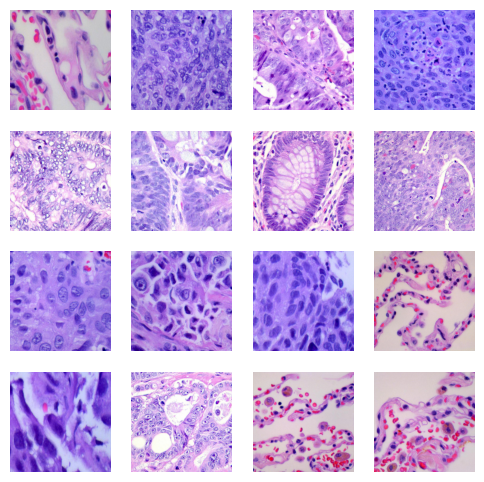

| It: 1 | Loss: 7.4923 | Time:   5.01s |


| It: 1001 | Loss: -59.5197 | Time: 359.01s |


| It: 2001 | Loss: -60.6622 | Time: 457.33s |


| It: 3001 | Loss: -61.0830 | Time: 462.15s |


| It: 4001 | Loss: -61.3231 | Time: 464.64s |


| It: 5001 | Loss: -61.4551 | Time: 463.86s |


| It: 6001 | Loss: -61.5612 | Time: 466.65s |


| It: 7001 | Loss: -61.6374 | Time: 464.64s |


| It: 8001 | Loss: -61.6822 | Time: 467.70s |


| It: 9001 | Loss: -61.7045 | Time: 467.86s |


| It: 1 | Loss: 3.7223 | Time:   0.50s |


| It: 1001 | Loss: -59.6906 | Time: 467.11s |


| It: 2001 | Loss: -60.6702 | Time: 464.91s |


| It: 3001 | Loss: -61.0815 | Time: 466.07s |


| It: 4001 | Loss: -61.2872 | Time: 464.58s |


| It: 5001 | Loss: -61.4470 | Time: 461.37s |


| It: 6001 | Loss: -61.5597 | Time: 463.57s |


| It: 7001 | Loss: -61.6209 | Time: 461.79s |


| It: 8001 | Loss: -61.6646 | Time: 463.44s |


| It: 9001 | Loss: -61.6869 | Time: 462.08s |


| It: 1 | Loss: -7.0288 | Time:   0.49s |


| It: 1001 | Loss: -60.0557 | Time: 463.98s |


| It: 2001 | Loss: -60.9862 | Time: 462.35s |


| It: 3001 | Loss: -61.2951 | Time: 463.62s |


| It: 4001 | Loss: -61.4657 | Time: 463.30s |


| It: 5001 | Loss: -61.5614 | Time: 463.40s |


| It: 6001 | Loss: -61.6329 | Time: 462.14s |


| It: 7001 | Loss: -61.6915 | Time: 459.02s |


| It: 8001 | Loss: -61.7289 | Time: 464.32s |


| It: 9001 | Loss: -61.7464 | Time: 464.20s |


| It: 1 | Loss: -32.4363 | Time:   0.50s |


| It: 1001 | Loss: -59.8872 | Time: 463.34s |


| It: 2001 | Loss: -60.7005 | Time: 462.27s |


| It: 3001 | Loss: -61.1211 | Time: 458.09s |


| It: 4001 | Loss: -61.3441 | Time: 463.83s |


| It: 5001 | Loss: -61.4777 | Time: 461.19s |


| It: 6001 | Loss: -61.5709 | Time: 462.61s |


| It: 7001 | Loss: -61.6373 | Time: 463.10s |


| It: 8001 | Loss: -61.6807 | Time: 459.49s |


| It: 9001 | Loss: -61.7017 | Time: 463.61s |


| It: 1 | Loss: 0.9720 | Time:   0.50s |


| It: 1001 | Loss: -59.3148 | Time: 463.21s |


| It: 2001 | Loss: -60.4383 | Time: 461.14s |


| It: 3001 | Loss: -60.9753 | Time: 462.21s |


| It: 4001 | Loss: -61.2210 | Time: 463.39s |


| It: 5001 | Loss: -61.3927 | Time: 462.46s |


| It: 6001 | Loss: -61.4963 | Time: 463.44s |


| It: 7001 | Loss: -61.5752 | Time: 463.65s |


| It: 8001 | Loss: -61.6259 | Time: 463.12s |


| It: 9001 | Loss: -61.6508 | Time: 462.72s |


BEST PSNR: 13.3260
MEDIAN PSNR: 12.4515
ALL PSNR: [11.5739, 11.7629, 13.3260, 12.7882, 12.7882]


<Figure size 400x300 with 0 Axes>

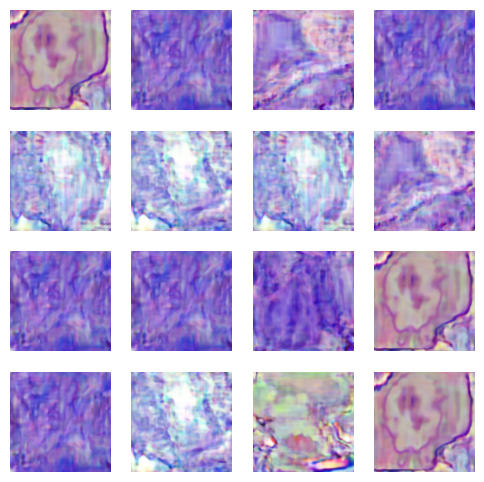

In [4]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

# data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, img_res=224, need_upscaling=False, num_iters=10000, plot_interval=1000, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)

#### ⭕ 3.2 Times 2

True Data:


<Figure size 400x300 with 0 Axes>

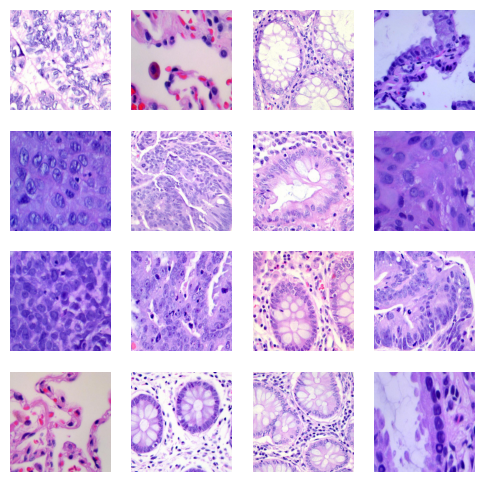

| It: 1 | Loss: 0.5216 | Time:   0.45s |


| It: 1001 | Loss: -58.4169 | Time: 463.21s |


| It: 2001 | Loss: -60.0489 | Time: 359.54s |


| It: 3001 | Loss: -60.7364 | Time: 356.10s |


| It: 4001 | Loss: -61.0611 | Time: 355.35s |


| It: 5001 | Loss: -61.2739 | Time: 355.74s |


| It: 6001 | Loss: -61.4182 | Time: 356.12s |


| It: 7001 | Loss: -61.5033 | Time: 356.46s |


| It: 8001 | Loss: -61.5644 | Time: 357.59s |


| It: 9001 | Loss: -61.5936 | Time: 357.77s |


| It: 1 | Loss: -3.8366 | Time:   0.35s |


| It: 1001 | Loss: -58.7001 | Time: 357.98s |


| It: 2001 | Loss: -60.2143 | Time: 356.54s |


| It: 3001 | Loss: -60.7897 | Time: 356.51s |


| It: 4001 | Loss: -61.0795 | Time: 358.12s |


| It: 5001 | Loss: -61.2757 | Time: 357.63s |


| It: 6001 | Loss: -61.4030 | Time: 357.32s |


| It: 7001 | Loss: -61.5001 | Time: 357.09s |


| It: 8001 | Loss: -61.5602 | Time: 356.17s |


| It: 9001 | Loss: -61.5897 | Time: 357.30s |


| It: 1 | Loss: -5.9677 | Time:   0.35s |


| It: 1001 | Loss: -59.3688 | Time: 357.06s |


| It: 2001 | Loss: -60.7378 | Time: 356.15s |


| It: 3001 | Loss: -61.1748 | Time: 344.81s |


| It: 4001 | Loss: -61.3641 | Time: 353.18s |


| It: 5001 | Loss: -61.4897 | Time: 357.10s |


| It: 6001 | Loss: -61.5796 | Time: 356.44s |


| It: 7001 | Loss: -61.6427 | Time: 356.78s |


| It: 8001 | Loss: -61.6831 | Time: 356.92s |


| It: 9001 | Loss: -61.7034 | Time: 357.56s |


| It: 1 | Loss: -36.0873 | Time:   0.35s |


| It: 1001 | Loss: -57.7960 | Time: 350.68s |


| It: 2001 | Loss: -59.5410 | Time: 356.27s |


| It: 3001 | Loss: -60.3336 | Time: 355.81s |


| It: 4001 | Loss: -60.7833 | Time: 351.96s |


| It: 5001 | Loss: -61.0363 | Time: 357.34s |


| It: 6001 | Loss: -61.2426 | Time: 356.73s |


| It: 7001 | Loss: -61.3623 | Time: 356.82s |


| It: 8001 | Loss: -61.4440 | Time: 356.73s |


| It: 9001 | Loss: -61.4814 | Time: 356.15s |


| It: 1 | Loss: -3.0641 | Time:   0.32s |


| It: 1001 | Loss: -59.2020 | Time: 354.73s |


| It: 2001 | Loss: -60.6159 | Time: 356.33s |


| It: 3001 | Loss: -61.0968 | Time: 355.53s |


| It: 4001 | Loss: -61.3183 | Time: 356.05s |


| It: 5001 | Loss: -61.4536 | Time: 356.56s |


| It: 6001 | Loss: -61.5525 | Time: 356.39s |


| It: 7001 | Loss: -61.6149 | Time: 356.00s |


| It: 8001 | Loss: -61.6638 | Time: 355.67s |


| It: 9001 | Loss: -61.6857 | Time: 353.64s |


BEST PSNR: 12.9951
MEDIAN PSNR: 12.6158
ALL PSNR: [12.9951, 12.6520, 12.6556, 12.1250, 12.1250]


<Figure size 400x300 with 0 Axes>

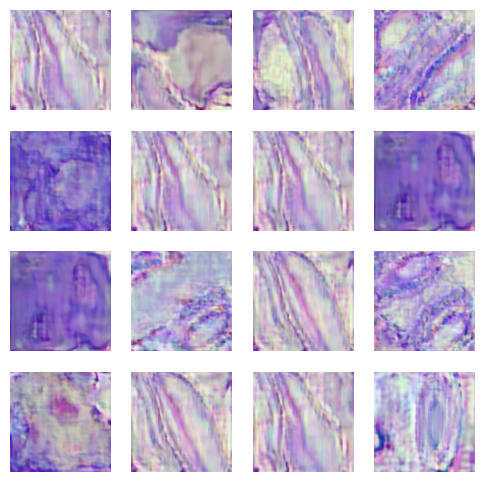

In [5]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

# data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, img_res=224, need_upscaling=False, num_iters=10000, plot_interval=1000, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)

#### ⭕ 3.3 Times 3

True Data:


<Figure size 400x300 with 0 Axes>

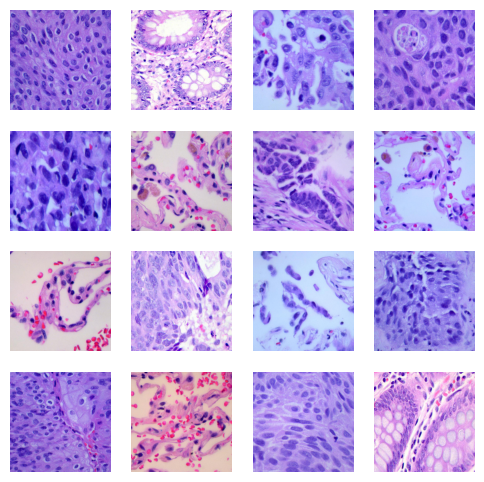

| It: 1 | Loss: -11.5816 | Time:   0.35s |


| It: 1001 | Loss: -59.5460 | Time: 353.33s |


| It: 2001 | Loss: -60.7873 | Time: 353.92s |


| It: 3001 | Loss: -61.1654 | Time: 354.77s |


| It: 4001 | Loss: -61.3459 | Time: 356.39s |


| It: 5001 | Loss: -61.4714 | Time: 353.79s |


| It: 6001 | Loss: -61.5569 | Time: 354.24s |


| It: 7001 | Loss: -61.6180 | Time: 355.92s |


| It: 8001 | Loss: -61.6588 | Time: 355.87s |


| It: 9001 | Loss: -61.6783 | Time: 355.77s |


| It: 1 | Loss: 1.1278 | Time:   0.35s |


| It: 1001 | Loss: -58.6279 | Time: 353.16s |


| It: 2001 | Loss: -60.3220 | Time: 356.71s |


| It: 3001 | Loss: -60.9081 | Time: 357.59s |


| It: 4001 | Loss: -61.1780 | Time: 355.71s |


| It: 5001 | Loss: -61.3558 | Time: 355.93s |


| It: 6001 | Loss: -61.4669 | Time: 356.06s |


| It: 7001 | Loss: -61.5483 | Time: 355.93s |


| It: 8001 | Loss: -61.5994 | Time: 352.44s |


| It: 9001 | Loss: -61.6255 | Time: 356.01s |


| It: 1 | Loss: -1.5344 | Time:   0.35s |


| It: 1001 | Loss: -58.7869 | Time: 355.90s |


| It: 2001 | Loss: -60.3304 | Time: 354.46s |


| It: 3001 | Loss: -60.8725 | Time: 355.30s |


| It: 4001 | Loss: -61.1605 | Time: 348.62s |


| It: 5001 | Loss: -61.3099 | Time: 349.34s |


| It: 6001 | Loss: -61.4349 | Time: 356.37s |


| It: 7001 | Loss: -61.5191 | Time: 356.17s |


| It: 8001 | Loss: -61.5754 | Time: 355.42s |


| It: 9001 | Loss: -61.6023 | Time: 355.91s |


| It: 1 | Loss: -24.3847 | Time:   0.35s |


| It: 1001 | Loss: -58.7864 | Time: 354.63s |


| It: 2001 | Loss: -60.2869 | Time: 357.53s |


| It: 3001 | Loss: -60.8488 | Time: 357.06s |


| It: 4001 | Loss: -61.1457 | Time: 356.61s |


| It: 5001 | Loss: -61.3070 | Time: 356.81s |


| It: 6001 | Loss: -61.4383 | Time: 357.69s |


| It: 7001 | Loss: -61.5185 | Time: 354.55s |


| It: 8001 | Loss: -61.5754 | Time: 357.87s |


| It: 9001 | Loss: -61.6027 | Time: 351.63s |


| It: 1 | Loss: -16.4969 | Time:   0.35s |


| It: 1001 | Loss: -58.1609 | Time: 355.57s |


| It: 2001 | Loss: -59.7000 | Time: 353.90s |


| It: 3001 | Loss: -60.4111 | Time: 355.66s |


| It: 4001 | Loss: -60.8327 | Time: 357.01s |


| It: 5001 | Loss: -61.0779 | Time: 357.45s |


| It: 6001 | Loss: -61.2717 | Time: 356.51s |


| It: 7001 | Loss: -61.3933 | Time: 352.96s |


| It: 8001 | Loss: -61.4692 | Time: 353.79s |


| It: 9001 | Loss: -61.5061 | Time: 357.10s |


BEST PSNR: 13.3457
MEDIAN PSNR: 12.9863
ALL PSNR: [12.6878, 13.1534, 12.4249, 13.3457, 13.3457]


<Figure size 400x300 with 0 Axes>

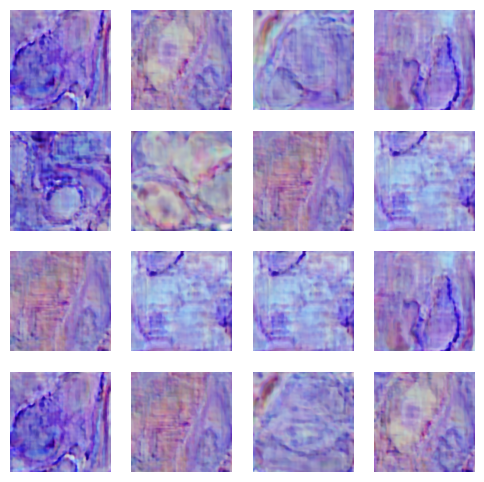

In [6]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

# data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, img_res=224, need_upscaling=False, num_iters=10000, plot_interval=1000, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)

#### ⭕ 3.4 Times 4

True Data:


<Figure size 400x300 with 0 Axes>

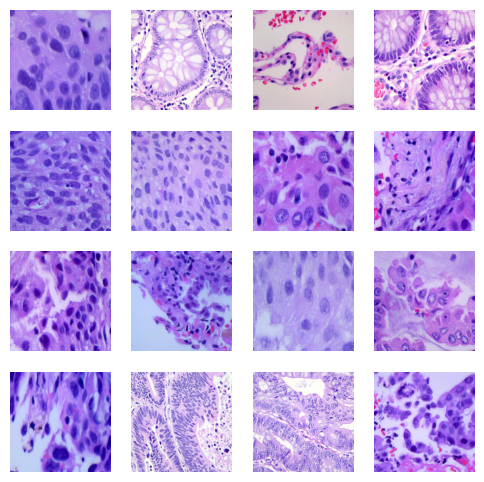

| It: 1 | Loss: -15.5011 | Time:   0.36s |


| It: 1001 | Loss: -60.0368 | Time: 356.65s |


| It: 2001 | Loss: -60.8467 | Time: 357.51s |


| It: 3001 | Loss: -61.1833 | Time: 356.27s |


| It: 4001 | Loss: -61.3655 | Time: 351.84s |


| It: 5001 | Loss: -61.5020 | Time: 356.22s |


| It: 6001 | Loss: -61.5842 | Time: 357.41s |


| It: 7001 | Loss: -61.6495 | Time: 357.09s |


| It: 8001 | Loss: -61.6858 | Time: 357.32s |


| It: 9001 | Loss: -61.7072 | Time: 358.27s |


| It: 1 | Loss: 4.1172 | Time:   0.35s |


| It: 1001 | Loss: -59.6455 | Time: 357.85s |


| It: 2001 | Loss: -60.5937 | Time: 356.62s |


| It: 3001 | Loss: -61.0772 | Time: 352.68s |


| It: 4001 | Loss: -61.3160 | Time: 352.46s |


| It: 5001 | Loss: -61.4681 | Time: 358.62s |


| It: 6001 | Loss: -61.5622 | Time: 357.95s |


| It: 7001 | Loss: -61.6322 | Time: 360.13s |


| It: 8001 | Loss: -61.6719 | Time: 358.90s |


| It: 9001 | Loss: -61.6917 | Time: 358.43s |


| It: 1 | Loss: 5.0616 | Time:   0.35s |


| It: 1001 | Loss: -59.9098 | Time: 359.63s |


| It: 2001 | Loss: -60.9680 | Time: 364.75s |


| It: 3001 | Loss: -61.3394 | Time: 365.51s |


| It: 4001 | Loss: -61.5101 | Time: 364.86s |


| It: 5001 | Loss: -61.6105 | Time: 361.63s |


| It: 6001 | Loss: -61.6765 | Time: 359.67s |


| It: 7001 | Loss: -61.7248 | Time: 361.45s |


| It: 8001 | Loss: -61.7545 | Time: 367.87s |


| It: 9001 | Loss: -61.7692 | Time: 366.79s |


| It: 1 | Loss: -2.2248 | Time:   0.36s |


| It: 1001 | Loss: -59.9087 | Time: 365.30s |


| It: 2001 | Loss: -60.8725 | Time: 367.37s |


| It: 3001 | Loss: -61.2594 | Time: 361.78s |


| It: 4001 | Loss: -61.4424 | Time: 436.93s |


| It: 5001 | Loss: -61.5625 | Time: 467.16s |


| It: 6001 | Loss: -61.6376 | Time: 465.19s |


| It: 7001 | Loss: -61.6917 | Time: 467.14s |


| It: 8001 | Loss: -61.7245 | Time: 460.84s |


| It: 9001 | Loss: -61.7413 | Time: 467.44s |


| It: 1 | Loss: -24.2756 | Time:   0.50s |


| It: 1001 | Loss: -59.9937 | Time: 467.14s |


| It: 2001 | Loss: -60.9053 | Time: 465.38s |


| It: 3001 | Loss: -61.2778 | Time: 467.16s |


| It: 4001 | Loss: -61.4706 | Time: 467.25s |


| It: 5001 | Loss: -61.5700 | Time: 467.77s |


| It: 6001 | Loss: -61.6470 | Time: 467.14s |


| It: 7001 | Loss: -61.6980 | Time: 467.96s |


| It: 8001 | Loss: -61.7306 | Time: 468.43s |


| It: 9001 | Loss: -61.7473 | Time: 466.72s |


BEST PSNR: 14.2463
MEDIAN PSNR: 13.6267
ALL PSNR: [14.0992, 13.3594, 13.7284, 12.7004, 12.7004]


<Figure size 400x300 with 0 Axes>

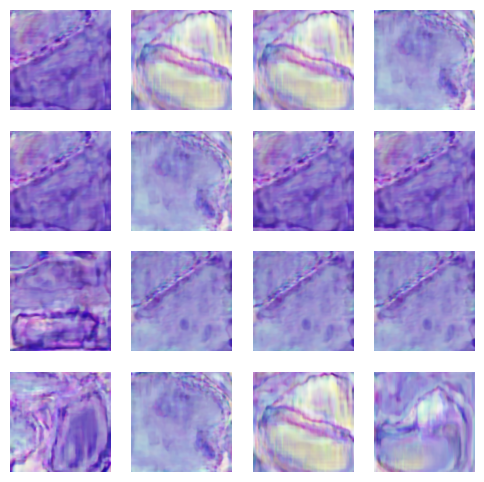

In [7]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

# data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, img_res=224, need_upscaling=False, num_iters=10000, plot_interval=1000, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)

#### ⭕ 3.5 Times 5

True Data:


<Figure size 400x300 with 0 Axes>

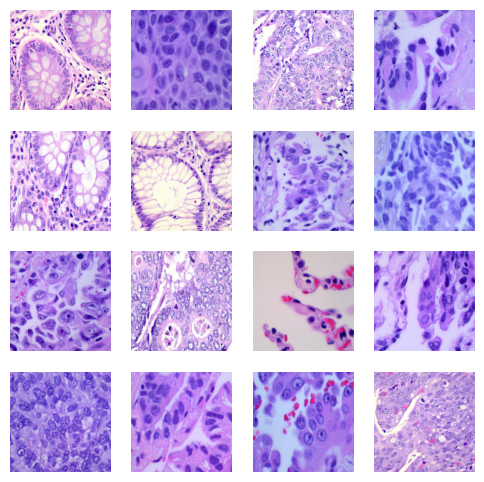

| It: 1 | Loss: 2.8424 | Time:   0.46s |


| It: 1001 | Loss: -60.7654 | Time: 466.49s |


| It: 2001 | Loss: -61.3364 | Time: 466.41s |


| It: 3001 | Loss: -61.5457 | Time: 466.21s |


| It: 4001 | Loss: -61.6487 | Time: 465.43s |


| It: 5001 | Loss: -61.7206 | Time: 466.16s |


| It: 6001 | Loss: -61.7675 | Time: 462.79s |


| It: 7001 | Loss: -61.8017 | Time: 465.68s |


| It: 8001 | Loss: -61.8243 | Time: 466.26s |


| It: 9001 | Loss: -61.8356 | Time: 465.74s |


| It: 1 | Loss: -13.2575 | Time:   0.55s |


| It: 1001 | Loss: -60.8076 | Time: 567.35s |


| It: 2001 | Loss: -61.2654 | Time: 567.30s |


| It: 3001 | Loss: -61.4858 | Time: 566.37s |


| It: 4001 | Loss: -61.6216 | Time: 566.42s |


| It: 5001 | Loss: -61.6954 | Time: 567.48s |


| It: 6001 | Loss: -61.7496 | Time: 568.66s |


| It: 7001 | Loss: -61.7882 | Time: 567.70s |


| It: 8001 | Loss: -61.8113 | Time: 568.69s |


| It: 9001 | Loss: -61.8233 | Time: 565.84s |


| It: 1 | Loss: -22.3272 | Time:   0.61s |


| It: 1001 | Loss: -60.9548 | Time: 567.68s |


| It: 2001 | Loss: -61.4516 | Time: 566.62s |


| It: 3001 | Loss: -61.6178 | Time: 567.01s |


| It: 4001 | Loss: -61.7022 | Time: 567.67s |


| It: 5001 | Loss: -61.7638 | Time: 568.27s |


| It: 6001 | Loss: -61.8086 | Time: 567.67s |


| It: 7001 | Loss: -61.8407 | Time: 565.91s |


| It: 8001 | Loss: -61.8625 | Time: 567.46s |


| It: 9001 | Loss: -61.8727 | Time: 567.39s |


| It: 1 | Loss: -3.6831 | Time:   0.56s |


| It: 1001 | Loss: -60.3858 | Time: 566.69s |


| It: 2001 | Loss: -61.1112 | Time: 567.36s |


| It: 3001 | Loss: -61.3516 | Time: 565.73s |


| It: 4001 | Loss: -61.4747 | Time: 567.11s |


| It: 5001 | Loss: -61.5858 | Time: 567.53s |


| It: 6001 | Loss: -61.6565 | Time: 567.69s |


| It: 7001 | Loss: -61.7098 | Time: 567.78s |


| It: 8001 | Loss: -61.7433 | Time: 566.86s |


| It: 9001 | Loss: -61.7590 | Time: 567.77s |


| It: 1 | Loss: -26.3779 | Time:   0.54s |


| It: 1001 | Loss: -60.8013 | Time: 567.26s |


| It: 2001 | Loss: -61.2943 | Time: 567.82s |


| It: 3001 | Loss: -61.5079 | Time: 566.94s |


| It: 4001 | Loss: -61.6107 | Time: 564.18s |


| It: 5001 | Loss: -61.6973 | Time: 569.11s |


| It: 6001 | Loss: -61.7594 | Time: 565.24s |


| It: 7001 | Loss: -61.8020 | Time: 567.53s |


| It: 8001 | Loss: -61.8281 | Time: 568.04s |


| It: 9001 | Loss: -61.8399 | Time: 568.77s |


BEST PSNR: 13.6033
MEDIAN PSNR: 13.0586
ALL PSNR: [13.4427, 13.6033, 13.4598, 12.1306, 12.1306]


<Figure size 400x300 with 0 Axes>

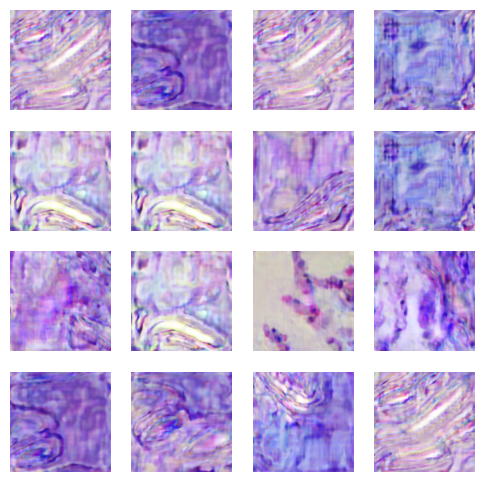

In [8]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

# data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, img_res=224, need_upscaling=False, num_iters=10000, plot_interval=1000, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)